In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
import pandas as pd

In [ ]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [ ]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

def load_data(ticker="NVDA", start_date="2020-01-01", end_date="2023-01-01"):
    data = yf.download(ticker, start=start_date, end=end_date)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[['Open', 'Close']])
    return data_scaled

data_scaled = load_data()


[*********************100%***********************]  1 of 1 completed


In [ ]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        self.length = len(X_data)

    def __getitem__(self, index):
        x = self.X_data[index]
        y = self.y_data[index]
        return x, y

    def __len__(self):
        return self.length

In [ ]:
def create_windows(arr, window):
  X,y=[],[]
  for i in range(window, len(arr)):
    X.append(arr[i-window:i])
    y.append(arr[i])
  return torch.reshape((torch.tensor(X)).to(torch.float32), (len(X), window, 1)), (torch.tensor(y)).to(torch.float32)

In [ ]:
device= "cuda:0" if torch.cuda.is_available() else "cpu" #training on GPU for convenience
print(device)


cuda:0


As we can see from the following graph, the model is accurately predicting the time series as we see a strong overlap between real and predicted data.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# Defining the CNN-LSTM model class
class CNNLSTMModel(nn.Module):
    def __init__(self):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=16, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        x = x.transpose(1, 2)  # [batch, features, sequence]
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.transpose(1, 2)  # [batch, sequence, features]
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x


def load_data(ticker="NVDA", start_date="2020-01-01", end_date="2023-01-01"):
    data = yf.download(ticker, start=start_date, end=end_date)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[['Open', 'Close']])
    return data_scaled

data_scaled = load_data()

def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Lookback period
lookback = 8
X, y = create_windows(data_scaled, lookback)

# Splitting the data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Converting to PyTorch tensors and create datasets
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# Dataloaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTMModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Evaluation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


[*********************100%***********************]  1 of 1 completed


Epoch 1: Train Loss: 0.3326, Test Loss: 0.2330
Epoch 2: Train Loss: 0.2155, Test Loss: 0.0738
Epoch 3: Train Loss: 0.1245, Test Loss: 0.0776
Epoch 4: Train Loss: 0.0810, Test Loss: 0.0327
Epoch 5: Train Loss: 0.0471, Test Loss: 0.0362
Epoch 6: Train Loss: 0.0397, Test Loss: 0.0321
Epoch 7: Train Loss: 0.0331, Test Loss: 0.0300
Epoch 8: Train Loss: 0.0288, Test Loss: 0.0288
Epoch 9: Train Loss: 0.0265, Test Loss: 0.0286
Epoch 10: Train Loss: 0.0261, Test Loss: 0.0283
Epoch 11: Train Loss: 0.0250, Test Loss: 0.0287
Epoch 12: Train Loss: 0.0239, Test Loss: 0.0292
Epoch 13: Train Loss: 0.0241, Test Loss: 0.0287
Epoch 14: Train Loss: 0.0236, Test Loss: 0.0308
Epoch 15: Train Loss: 0.0251, Test Loss: 0.0305
Epoch 16: Train Loss: 0.0241, Test Loss: 0.0270
Epoch 17: Train Loss: 0.0228, Test Loss: 0.0268
Epoch 18: Train Loss: 0.0222, Test Loss: 0.0267
Epoch 19: Train Loss: 0.0221, Test Loss: 0.0264
Epoch 20: Train Loss: 0.0229, Test Loss: 0.0267
Epoch 21: Train Loss: 0.0236, Test Loss: 0.0299
E

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            predictions.append(y_pred.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
    return np.vstack(predictions), np.vstack(actuals)


Epoch 1/30 training complete.
Epoch 2/30 training complete.
Epoch 3/30 training complete.
Epoch 4/30 training complete.
Epoch 5/30 training complete.
Epoch 6/30 training complete.
Epoch 7/30 training complete.
Epoch 8/30 training complete.
Epoch 9/30 training complete.
Epoch 10/30 training complete.
Epoch 11/30 training complete.
Epoch 12/30 training complete.
Epoch 13/30 training complete.
Epoch 14/30 training complete.
Epoch 15/30 training complete.
Epoch 16/30 training complete.
Epoch 17/30 training complete.
Epoch 18/30 training complete.
Epoch 19/30 training complete.
Epoch 20/30 training complete.
Epoch 21/30 training complete.
Epoch 22/30 training complete.
Epoch 23/30 training complete.
Epoch 24/30 training complete.
Epoch 25/30 training complete.
Epoch 26/30 training complete.
Epoch 27/30 training complete.
Epoch 28/30 training complete.
Epoch 29/30 training complete.
Epoch 30/30 training complete.


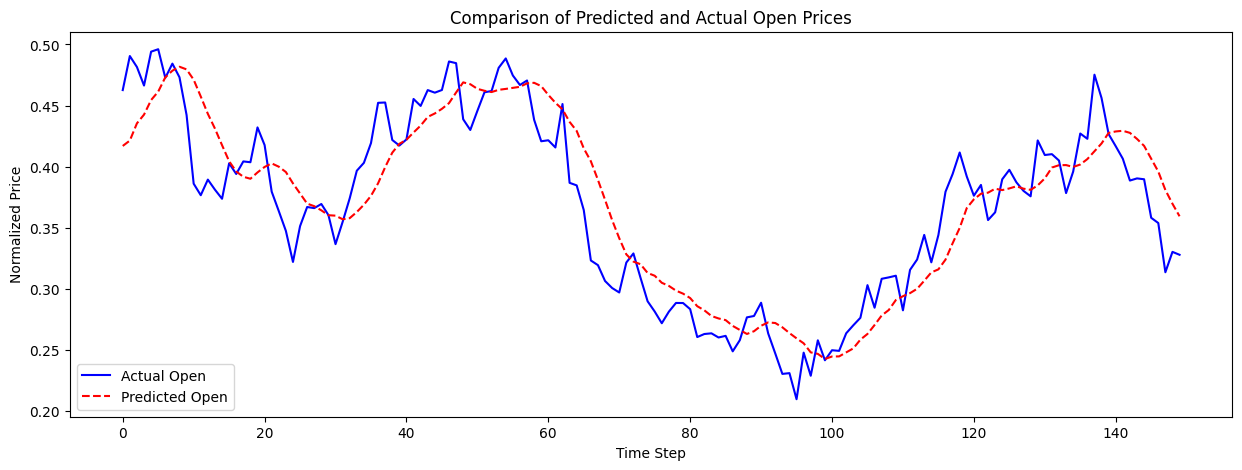

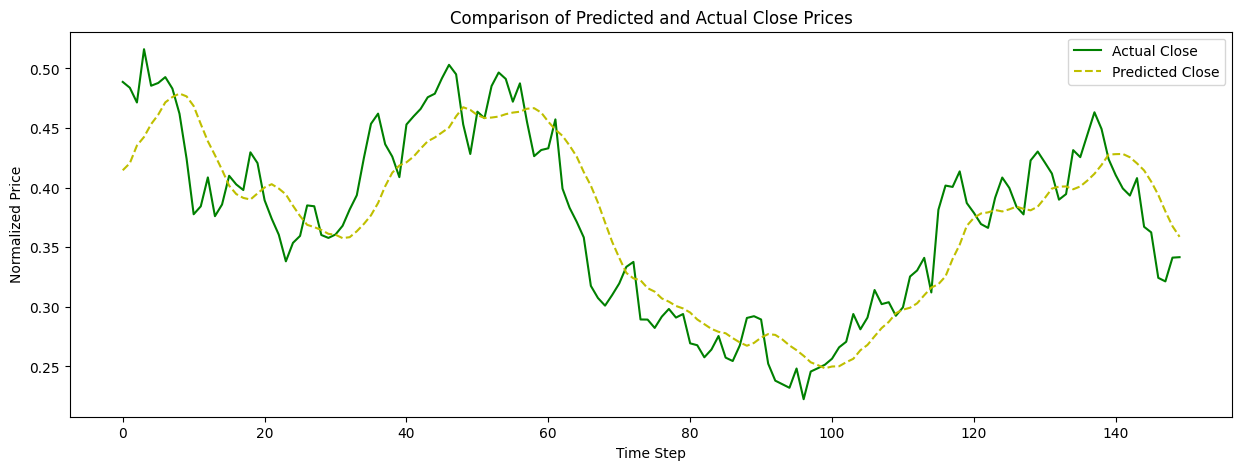

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


class CNNLSTMModel(nn.Module):
    def __init__(self):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=16, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        x = x.transpose(1, 2)  # [batch, features, sequence]
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.transpose(1, 2)  # [batch, sequence, features]
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = CNNLSTMModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training function
def train_model(model, train_loader, test_loader, epochs):
    model.train()
    for epoch in range(epochs):
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs} training complete.")

    # Evaluate the model
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())

    return np.vstack(predictions), np.vstack(actuals)

# Plotting results function

def plot_results(predictions, actuals):
    # Plotting for 'Open' prices
    plt.figure(figsize=(15, 5))
    plt.plot(actuals[:, 0], 'b', label='Actual Open')
    plt.plot(predictions[:, 0], 'r--', label='Predicted Open')
    plt.title('Comparison of Predicted and Actual Open Prices')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.show()

    # Plotting for 'Close' prices
    plt.figure(figsize=(15, 5))
    plt.plot(actuals[:, 1], 'g', label='Actual Close')
    plt.plot(predictions[:, 1], 'y--', label='Predicted Close')
    plt.title('Comparison of Predicted and Actual Close Prices')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.show()

predictions, actuals = train_model(model, train_loader, test_loader, epochs=30)
plot_results(predictions, actuals)


In [ ]:

torch.save(model.state_dict(), 'cnn-lstm_model_weights.pth')